# 第 5 章 决策树
## 5.2 特 征 选 择
### 算法 5.1 （信息增益的算法）
![](https://qiniu.lianghao.work/markdown/20220505095834.png)

In [16]:
import csv
import numpy as np

def readCsv(filepath):
    D = []
    with open(filepath, encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            D.append(row)
        f.close()
    return D

def extractFeatures(D):
    '''从数据集中提取每个特征（包括分类）的不同取值'''
    features = dict()
    for i in range(0, len(D[0])):
        tmp = []
        for j in range(0, len(D)):
            if D[j][i] not in tmp:
                tmp.append(D[j][i])
        if i != len(D[0]) - 1:
            features['A' + str(i+1)] = tmp
        else:
            features['C'] = tmp
    return features

def calFeaturePa(featureId, featureVal, D):
    '''统计每个特征不同取值的个数（如果除以总个数的话，就是分布了）'''
    pa = dict()
    for name in featureVal:
        num = 0
        for i in range(0, len(D)):
            if D[i][featureId] == name:
                num += 1
        pa[name] = num
    return pa

def entropy(pa):
    '''计算概率分布的熵， pa为概率分布'''
    sum = 0.0
    for p in pa:
        if p != 0:
            sum += p * np.log2(p)
        else:
            sum += 0
    return -1 * sum

def conditionEntropy(featureName, featureId, Features, D):
    '''计算条件熵'''
    Y = Features['C']
    pa_feature = calFeaturePa(featureId=featureId, featureVal=Features[featureName], D=D)
    sum = 0.0
    for x_i in Features[featureName]:
        H_Y_xi = []
        for y_i in Y:
            tmp = 0
            for i in range(0, len(D)):
                if D[i][featureId] == x_i and D[i][len(D[0])-1] == y_i:
                    tmp += 1
            H_Y_xi.append(tmp / pa_feature[x_i])
        sum += (pa_feature[x_i] / len(D)) * entropy(H_Y_xi)
    return sum

def gainInformation(D, featureName, featureId, Features, entropY):
    """计算信息增益"""
    ConditionEntropy = conditionEntropy(featureName=featureName, featureId=featureId, Features=Features, D=D)
    gi = entropY - ConditionEntropy
    return gi

def gainInformationRatio(D, featureName, featureId, Features, entropY):
    """计算信息增益比"""
    gi = gainInformation(D=D, featureName=featureName, featureId=featureId, Features=Features, entropY=entropY)
    featureClass = dict()
    for i in range(0, len(D)):
        if D[i][featureId] not in featureClass:
            featureClass[D[i][featureId]] = 1
        else:
            featureClass[D[i][featureId]] += 1
    featurPa = [val / len(D) for val in featureClass.values()]
    gir = gi / entropy(featurPa)
    return gir

def selectBestFeatures(D, Features):
    """从当前数据集D和特征集A中根据信息增益选择最优特征"""
    criterion = dict()
    featureId = 0
    entropY = entropy([val / len(D) for val in calFeaturePa(featureId=len(D[0])-1, featureVal=Features['C'], D=D).values()])
    bestName = ''
    bestVal = 0
    for name in Features.keys():
        if name != 'C':
            # criterion[name] = gainInformation(D, name, featureId, Features, entropY)
            criterion[name] = gainInformationRatio(D, name, featureId, Features, entropY)
            featureId += 1
            if bestVal < criterion[name]:
                bestVal = criterion[name]
                bestName = name
    return bestName, bestVal

### 例 5.2
**对下表所给的训练数据集D，根据信息增益尊则选择最优的特征**
![](https://qiniu.lianghao.work/markdown/20220505100016.png)

In [3]:
# 读取训练数据集D
D = readCsv('G:/LiangHao/Master/Learning/MachineLearning/test.csv')
# 抽取特征集
A = extractFeatures(D)
A

{'A1': ['adolescent', 'middle', 'older'],
 'A2': ['no', 'yes'],
 'A3': ['no', 'yes'],
 'A4': ['general', 'good', 'verygood'],
 'C': ['no', 'yes']}

In [4]:
# 计算各个特征的信息增益
bestName, bestValue = selectBestFeatures(D, A)
print("选择特征 {0} 作为最优特征，其信息增益为{1}".format(bestName, round(bestValue, 4)))

{'A1': 0.08300749985576883, 'A2': 0.32365019815155627, 'A3': 0.4199730940219749, 'A4': 0.36298956253708536}
选择特征 A3 作为最优特征，其信息增益为0.42


## 5.3 决策树的生成
### 例 5.3 对下表中的训练数据集，利用ID3算法建立决策树
![](https://qiniu.lianghao.work/markdown/20220505100016.png)
生成的ID3决策树如下所示
![](https://qiniu.lianghao.work/markdown/20220505202110.png)


In [2]:
def divDataSet(D, Feature, bestName):
    featureId = 0
    for key in Feature.keys():
        if key == bestName:
            break
        featureId += 1
    # div features
    divD = dict()
    for key in Feature[bestName]:
        tmp = []
        for i in range(0, len(D)):
            if D[i][featureId] == key:
                D[i].pop(featureId)
                tmp.append(D[i])
        divD[key] = tmp
    Feature.pop(bestName)
    return divD, Feature

def sampleClass(D):
    clc = dict()
    cid = len(D[0]) - 1
    for i in range(0, len(D)):
        if D[i][cid] not in clc:
            clc[D[i][cid]] = 1
        else:
            clc[D[i][cid]] += 1
    return clc

def sameClass(D):
    clc = sampleClass(D)
    if len(clc.keys()) == 1:
        return True
    return False

def label(D):
    clc = sampleClass(D)
    maxn = ''
    maxv = 0
    for key, value in clc.items():
        if maxv < value:
            maxv = value
            maxn = key
    return maxn, maxv

def showTree(parent, tree):
    if tree == None:
        return
    print(parent, ' -- ', tree.relation, '  --', tree.value)
    for i in range(0, len(tree.children)):
        showTree(tree.value, tree.children[i])

def MakeGraph(parent, tree, g, idx):
    if tree == None:
        return
    if idx > 1:
        if 'A' not in tree.value:
            g.node(name=parent+" "+tree.value)
            g.edge(parent, parent+" "+tree.value, tree.relation)
        else:
            g.node(name=tree.value)
            g.edge(parent, tree.value, tree.relation)
    for i in range(0, len(tree.children)):
        MakeGraph(tree.value, tree.children[i], g, idx + 1)

In [3]:
class Decision:
    def __init__(self, value, relation):
        self.value = value
        self.children = []
        self.relation = relation

In [4]:
def ID3Tree(D, Feature, relation):
    if sameClass(D) or len(Feature) == 1:
        name, value = label(D)
        return Decision(value=name, relation=relation)

    bestName, bestValue = selectBestFeatures(D, Feature)
    node = Decision(bestName, relation)
    divd, divf = divDataSet(D, Feature, bestName)
    Keys = [key for key in divd.keys()]
    for i in range(0, len(Keys)):
        # node.children.append(ID3Tree(divd[Keys[i]], divf, node.value))
        node.children.append(ID3Tree(divd[Keys[i]], divf, Keys[i]))
    return node


In [40]:
D = readCsv('G:/LiangHao/Master/Learning/MachineLearning/test.csv')
A = extractFeatures(D)
root = ID3Tree(D, A, None)

In [41]:
showTree(None, root)

None  --  None   -- A3
A3  --  no   -- A2
A2  --  no   -- no
A2  --  yes   -- yes
A3  --  yes   -- yes


In [42]:
from graphviz import Digraph
# 创建对象
g = Digraph('decisionTree')
MakeGraph('start', root, g, 1)
g.view()

'decisionTree.gv.pdf'

![](https://qiniu.lianghao.work/markdown/20220505202110.png)

## 5.5 CART算法
### 5.5.1 CART树生成
#### 例 5.4
根据下表给定的训练数据集，应用**CART算法**生成决策树
![](https://qiniu.lianghao.work/markdown/20220505100016.png)

In [9]:
def giNi(D):
    """计算Gini熵"""
    clc = sampleClass(D)
    N = len(D)
    sum = 0.0
    for key, value in clc.items():
        sum += (value / N) ** 2
    gini = 1 - sum
    return gini

def giniFeatureValue(D, FeatureId, FeatureValue):
    """根据特征A和其可能的值a计算其基尼指数"""
    d1, d2 = [], []
    for i in range(0, len(D)):
        if D[i][FeatureId] == FeatureValue:
            d1.append(D[i])
        else:
            d2.append(D[i])
    gini = (len(d1) / len(D)) * giNi(d1) + (len(d2) / len(D)) * giNi(d2)
    return gini

def giniFeature(D, Features, FeatureName):
    """找到某一特征内的最优切分点"""
    featureId = 0
    for key in Features.keys():
        if key == FeatureName:
            break
        featureId += 1
    alpha = ''
    maxgini = 1e10
    for key in Features[FeatureName]:
        gini = giniFeatureValue(D, featureId, key)
        if maxgini > gini:
            maxgini = gini
            alpha = key
    return maxgini, alpha

def selectBestNode(D, Features):
    """找到最优特征和最优切分点"""
    minName = ''
    mingni = 1e10
    alpha = ''
    for featurName in Features.keys():
        if featurName != 'C':
            gini, nodeName = giniFeature(D, Features, featurName)
            if mingni > gini:
                minName = featurName
                mingni = gini
                alpha = nodeName
    return minName, alpha, mingni

In [43]:
class carTree:
    """CART树"""
    def __init__(self, value, relation):
        self.value = value
        self.relation = relation
        self.left = None
        self.right = None

In [51]:
def MakeCarTree(D, Feature, relation):
    """Cart 生成树"""
    if sameClass(D) == True or len(Feature) == 1:
        name, value = label(D)
        return carTree(value=name, relation=relation)
    bestFeatureName, bestNode, _ = selectBestNode(D, Feature)
    node = carTree(value=bestFeatureName, relation=relation)
    divd, divf = divDataSet(D, Feature, bestFeatureName)
    node.right = MakeCarTree(divd[bestNode], divf, bestNode)
    divd.pop(bestNode)
    keys = [key for key in divd.keys()]
    node.left = MakeCarTree(divd[keys[0]], divf, keys[0])
    return node

def showCarTree(parent, tree):
    """打印 Cart树"""
    if tree == None:
        return
    print(parent, ' -- ', tree.relation, '  --', tree.value)
    showCarTree(tree.value, tree.left)
    showCarTree(tree.value, tree.right)

def MakeCartGraph(parent, tree, g, idx):
    """制作生成树的图"""
    if tree == None:
        return
    if idx > 1:
        if 'A' not in tree.value:
            g.node(name=parent+" "+tree.value)
            g.edge(parent, parent+" "+tree.value, tree.relation)
        else:
            g.node(name=tree.value)
            g.edge(parent, tree.value, tree.relation)
    MakeCartGraph(tree.value, tree.left, g, idx + 1)
    MakeCartGraph(tree.value, tree.right, g, idx + 1)

In [48]:
D = readCsv('G:/LiangHao/Master/Learning/MachineLearning/test.csv')
Features = extractFeatures(D)

In [49]:
cartree = MakeCarTree(D, Features, None)

In [50]:
showCarTree(None, cartree)

None  --  None   -- A3
A3  --  yes   -- yes
A3  --  no   -- A2
A2  --  yes   -- yes
A2  --  no   -- no


In [42]:
from graphviz import Digraph
gCart = Digraph('carTree')
MakeCartGraph('start', cartree, gCart, 1)
gCart.view()

'carTree.gv.pdf'

![](https://qiniu.lianghao.work/markdown/20220505211906.png)

## 习题
### 5.1 根据下表所给的训练数据集，利用**信息增益比 C4.5算法**生成决策树
![](https://qiniu.lianghao.work/markdown/20220505100016.png)
根据下列程序，可以得到C4.5决策树如下
![](https://qiniu.lianghao.work/markdown/20220506103841.png)

In [10]:
'''
在ID3算法中，修改选择最优条件的函数selectBest， 将其中的准则（信息增益）替换成信息增益比
'''
def selectBestFeaturesRation(D, Features):
    """从当前数据集D和特征集A中根据信息增益选择最优特征"""
    criterion = dict()
    featureId = 0
    entropY = entropy([val / len(D) for val in calFeaturePa(featureId=len(D[0])-1, featureVal=Features['C'], D=D).values()])
    bestName = ''
    bestVal = 0
    for name in Features.keys():
        if name != 'C':
            # criterion[name] = gainInformation(D, name, featureId, Features, entropY)
            criterion[name] = gainInformationRatio(D, name, featureId, Features, entropY)
            featureId += 1
            if bestVal < criterion[name]:
                bestVal = criterion[name]
                bestName = name
    return bestName, bestVal

def C45Tree(D, Feature, relation):
    if sameClass(D) or len(Feature) == 1:
        name, value = label(D)
        return Decision(value=name, relation=relation)

    bestName, bestValue = selectBestFeatures(D, Feature)
    node = Decision(bestName, relation)
    divd, divf = divDataSet(D, Feature, bestName)
    Keys = [key for key in divd.keys()]
    for i in range(0, len(Keys)):
        # node.children.append(ID3Tree(divd[Keys[i]], divf, node.value))
        node.children.append(ID3Tree(divd[Keys[i]], divf, Keys[i]))
    return node

In [27]:
D = readCsv('G:/LiangHao/Master/Learning/MachineLearning/test.csv')
A = extractFeatures(D)
root = C45Tree(D, A, None)
from graphviz import Digraph
# 创建对象
g = Digraph('C4.5')

In [28]:
showTree(None, root)

None  --  None   -- A3
A3  --  no   -- A2
A2  --  no   -- no
A2  --  yes   -- yes
A3  --  yes   -- yes


In [29]:
MakeGraph('start', root, g, 1)
g.view()

'C4.5.gv.pdf'

![](https://qiniu.lianghao.work/markdown/20220506103841.png)

### 5.2 根据下表中的训练数据， 试用平方误差损失准则生成一个二叉回归树
![](https://qiniu.lianghao.work/markdown/20220506104214.png)

#### 1. 使用 sklearn 的 方法 对数据进行拟合

In [30]:
import graphviz
from sklearn import tree
x = [i for i in range(1, 11)]
y = [4.50,  4.75, 4.91, 5.34, 5.80, 7.05, 7.90, 8.23, 8.70, 9.00]
# sklearn.tree 要求数据是二维的
X = [[item] for item in x]
Y = [[item] for item in y]
# 创建 决策回归树
regression = tree.DecisionTreeRegressor()
# 对训练数据进行拟合
regression.fit(X, Y)
# 将训练好的回归树可视化
dot_data = tree.export_graphviz(regression, out_file=None)
graph = graphviz.Source(dot_data)
# 保存到 iris.pdf中
graph.render('iris')

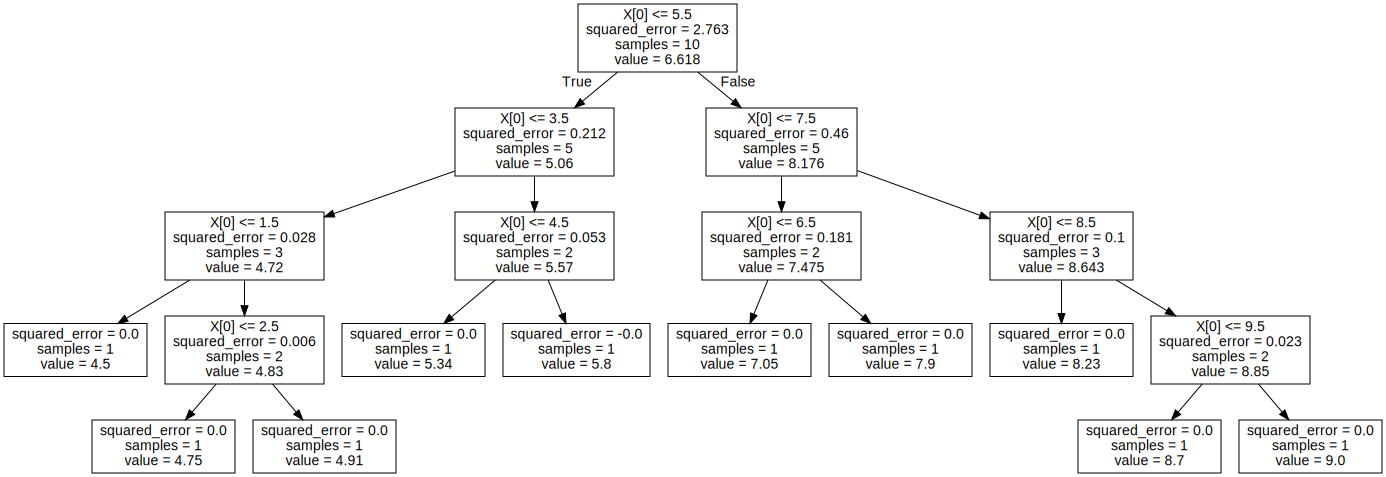

In [48]:
graph

### 5.3 证明CART剪枝算法中，当$\alpha$确定时，存在唯一的最小子树$T_\alpha$使损失函数$C_\alpha(T)$最小
**解：由剪枝算法可得以下性质**：
1. 剪枝只与内部结点$t$有关，当$C_\alpha(t)<C_\alpha(T_t)$时，对以结点$t$为根结点的子树$T_t$进行剪枝
2. 假设剪枝前子树为$T_0$，剪枝后的子树为$T_t$，则$C\alpha(T_t)\ge C_\alpha(T_0)$

分别证明**存在性**和**唯一性**
1. **存在性**：当$\alpha$确定时，会生成多棵子树，一定存在损失函数最小的子树
2. **唯一性**（反证法）：假设$\alpha$确定时，存在两棵损失函数最小的子树$T_1,T_2$
- 假设$T_1,T_2$子树相交（即结点$t_2$是$t_1$的子结点）：此时$T_1$子树是由对$T_2$剪枝得到的，因此存在唯一的子树使损失函数最小。
- 假设$T_1,T_2$子树不相交（结点$t_1,t_2$是兄弟结点）：因为，$C_\alpha(T_1)=C_\alpha(T_2)$且最小，因此，可以对子树$T_1,T_2$进行剪枝，剪枝得到的子树为$T_3$，根据剪枝规则可得，$C_\alpha(T_4)$最小，这与事实相悖，因此不存在两棵损失函数最小的子树。

### 5.4 证明CART剪枝算法中求出的子树序列$\{T_0,T_1,\cdots,T_n\}$分别是区间$\alpha\in[\alpha_i,\alpha_{i+1})$的最优子树$T_\alpha$，其中$i=0,1,\cdots,n,\ 0=\alpha_0<\alpha_1<\cdots<\alpha_n<\inf$
[Reference](https://github.com/fengdu78/lihang-code/blob/master/%E7%AC%AC05%E7%AB%A0%20%E5%86%B3%E7%AD%96%E6%A0%91/5.DecisonTree.ipynb)
**解**：
1. $\alpha=0$时，$C_\alpha(T)=C(T)$，此时整体树$T_0$是最优的
2. $\alpha=+\inf$时，此时，根节点组成的单结点树$T_n$是最优的
3. $0\le\alpha<+\inf$时：
每次剪枝都是减去决策树以某个内部结点为根节点的子树，然后将这个内部结点作为叶结点进行保留。内部结点以外的其他结点是没有变化的，因此整体的损失函数时，只需要计算该内部结点局部的损失值的变化，即计算内部结点剪枝前后的损失函数。
- 从整体树$T_0$进行剪枝，对$T_0$内部任意结点$t$
- 剪枝前状态：有$T_t$个**叶子结点**，预测误差为$C(T_t)$，损失函数为$C_\alpha(T_t)=C(T_t)+\alpha|T_t|$
- 剪枝后状态：只有一个叶子结点$t$，预测误差是$C(t)$，损失函数为$C_\alpha(t)=C(t)+\alpha$
- 因此，存在一个$\alpha$使得剪枝前后的损失值相等：$\alpha=\frac{C(t)-C(T_t)}{|T_t|-1}$
- 找到了这个$\alpha$就找到了待剪枝的内部结点$t$
- 令$g(t)$表示剪枝后整体损失函数减少的程度，$g(t)=\alpha$
- 在$T(0)$中剪去$g(t)$最小的子树$T_t$，将得到的子树作为$T_1$，同时将最小的$g(t)=\alpha_1$，此时，$T_1$为$[\alpha_1,\alpha_2)$的最优子树
- 依次类推，子树$T_i$是$[\alpha_i,\alpha_{i+1})$的最优子树